In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import importlib

from tqdm import tqdm_notebook

In [2]:
try: importlib.reload(msp)
except: import ModSimPy as msp  # Библиотека с github - предназначена для имит. моделирования

# Helpful functions

In [3]:
type_priority_mapping = {k:v for k,v in zip(['gold','silver','regular'],range(1,4))}
type_salary_mapping = {k:v for k,v in zip(['gold','silver','regular'], [600*8, 500*8, 400*8])}

In [4]:
def to_next_timestep(system, state, tqdm):
    """
    Переводит систему в следующий момент времени
    """
    state.time_cur += system.timedelta
    tqdm.update(system.timedelta.seconds)

In [5]:
def calc_statistic(state):
    """
    Требуемая от симуляции статистика
    """
    data = pd.Series({
        },
        name=state.time_cur)
    return data

In [6]:
def get_datetime(hours, mins, secs=None):
    return datetime.datetime(2018,1,1,hours,mins, secs if secs else 0)

In [7]:
def get_panel(system, state):
    ds = pd.merge(state.connections_ds, state.clients_ds,
              left_on='client_id', right_on='id', suffixes=['_con','_client'], how='right').drop('id_client',axis=1)
    ds = pd.merge(ds, system.operators_ds,
                  left_on='operator_id', right_on='id', suffixes=['','_operator'], how='left').drop('id',axis=1)
    ds = pd.merge(ds, state.queue_ds,
                  left_on='client_id', right_on='client_id', suffixes=['','_queue'], how='left')
    ds = ds.rename(columns={'id_con':'id_connection', 'operator_id':'id_operator', 'client_id':'id_client','line_id':'id_line',
                            'closed':'connection_closed',
                            'type':'type_client', 'opeartor_type':'type_operator',
                            'time_start':'time_start_connection',
                            'call_start_time':'time_start_call',
                            'max_waiting_time':'client_max_waiting_time',
                            'missed':'client_missed',
                            'start_work_time':'operator_start_work_time',
                            'priority':'client_priority',
                            'time_from':'time_quque_from',
                            'exit':'queue_exit'
                           })
    ds['hour'] = [x.hour for x in ds['time_start_call']]
    ds['client_missed'] = ds['client_missed'].astype(int)
    return ds

In [8]:
def get_line_loads(panel_ds, time_from=get_datetime(7,0), time_to=get_datetime(19,0)):
    all_time = pd.DataFrame(pd.date_range(time_from, time_to, freq='s'), columns=['ctime'])[:-1]
    all_time.index = all_time['ctime']
    tts = []
    for idx, row in panel_ds.iterrows():
        tt = all_time.loc[row['time_start_connection']:row['time_start_connection']+row['time_to_service']][:-1]
        for f in ['id_connection', 'id_line', 'id_client', 'id_operator']:
            tt[f] = row[f]
        tts.append(tt)
    line_loads_ds = pd.concat(tts)
    del tts
    line_loads_ds = pd.merge(all_time, line_loads_ds, on='ctime', how='left')
    line_loads_ds = line_loads_ds.fillna(-1)
    line_loads_ds = line_loads_ds.pivot_table(index='ctime', columns='id_line', values='id_connection')
    line_loads_ds = line_loads_ds.drop(-1,axis=1)
    line_loads_ds = line_loads_ds.fillna(0)
    return line_loads_ds

In [9]:
def add_operator(type_, start_work_time, ds):
    ds.loc[len(ds)] = {'id':len(operators_ds), 'type':type_, 'start_work_time':start_work_time}
def add_operators(ar, ds):
    for t, swt in ar: add_operator(t, swt, ds)

# Подготовка данных

Заданные значения частот звонков разных клиентов

In [10]:
calls_stat_ds = pd.DataFrame()
calls_stat_ds['regular_clients'] = [87, 165, 236, 323, 277, 440, 269, 342, 175, 273, 115,  56]
calls_stat_ds['vip_clients'] = [89, 243, 221, 180, 301, 490, 394, 347, 240, 269, 145,  69]
calls_stat_ds['silver_clients'] = 0.68*calls_stat_ds['vip_clients']
calls_stat_ds['gold_clients'] = calls_stat_ds['vip_clients']-calls_stat_ds['silver_clients']
for f in calls_stat_ds.columns:
    calls_stat_ds[f+'_per_sec'] = calls_stat_ds[f]/3600
calls_stat_ds.index = range(7,19)
print('Частота звонков')
calls_stat_ds

Частота звонков


,regular_clients,vip_clients,silver_clients,gold_clients,regular_clients_per_sec,vip_clients_per_sec,silver_clients_per_sec,gold_clients_per_sec
7,87,89,60.52,28.48,0.024167,0.024722,0.016811,0.007911
8,165,243,165.24,77.76,0.045833,0.067500,0.045900,0.021600
9,236,221,150.28,70.72,0.065556,0.061389,0.041744,0.019644
10,323,180,122.40,57.60,0.089722,0.050000,0.034000,0.016000
11,277,301,204.68,96.32,0.076944,0.083611,0.056856,0.026756
12,440,490,333.20,156.80,0.122222,0.136111,0.092556,0.043556
13,269,394,267.92,126.08,0.074722,0.109444,0.074422,0.035022
14,342,347,235.96,111.04,0.095000,0.096389,0.065544,0.030844
15,175,240,163.20,76.80,0.048611,0.066667,0.045333,0.021333
16,273,269,182.92,86.08,0.075833,0.074722,0.050811,0.023911


In [11]:
operators_ds = pd.DataFrame(columns=['id', 'type', 'start_work_time'])

add_operators([['regular', get_datetime(7,0)],
               ['regular', get_datetime(11,0)],
               ['silver',  get_datetime(7,0)],
               ['gold',    get_datetime(8,0)]],
             operators_ds)

In [12]:
for i in range(50):
    add_operator('regular', get_datetime(7,0), operators_ds)

# Модель 1

In [13]:
def init_state(system):
    """
    Задаёт первичное состояние системы
    """
    state = msp.State(
        time_cur=system.time_start,  # Текущее время
        # Данные по линиям связи (возможно уже не нужны)
        lines_ds=pd.DataFrame({'time_to_free':0 for i in range(system.n_lines)}, index=range(system.n_lines)),
        # Данные по всем клиентам
        clients_ds=pd.DataFrame(columns=['id','type','call_start_time', 'max_waiting_time', 'missed']),
        # Данные по всем соединениям операторов с клиентами
        connections_ds=pd.DataFrame(columns=['id', 'operator_id', 'client_id', 'line_id', 'time_start','time_to_service', 'closed']),
        # Очередь клиентов на соединение
        queue_ds=pd.DataFrame(columns=['client_id','priority', 'time_from', 'exit']  # 
        )
    )
    return state

In [14]:
def generate_clients(system, state):
    """
    Генератор клиентов. Использует заданные частоты звонков клиентов.
    За одну секунду генерируется несколько клиентов, т.к. могут позвонить одновременно золотой и обычные клиент.
    """
    probs = [system.calls_stat.loc[state.time_cur.hour, f'{t}_clients_per_sec'] for t in system.client_types]
    bools = [msp.flip(p) for p in probs]  # Перевод вероятности в True/False
    clients = [ctype for ctype, b in zip(system.client_types, bools) if b] 
    ids = []
    for ctype in clients:
        data = {'id':len(state.clients_ds),
                'type':ctype,
                'call_start_time':state.time_cur,
                'max_waiting_time':300,  # seconds  # временная константа 
                'missed':False}  # повесил-ли клиент трубку
        ids.append(data['id'])
        state.clients_ds.loc[data['id']] = data
    return ids

In [15]:
def add_clients_to_queue(state, clients_ids):
    """
    Добавление клиентов с заданными id в очередь ожидания
    """
    for cid in clients_ids:
        data = {'client_id':cid,
                'priority': type_priority_mapping[state.clients_ds.loc[cid,'type']],
                'time_from':state.time_cur,
                'exit':False}
        state.queue_ds = state.queue_ds.append(data, ignore_index=True)

In [123]:
def drop_clients_from_queue(state):
    """
    Моделирование "бросания трубки" недождавшихся клиентов
    """
    cds = pd.merge(state.queue_ds, state.clients_ds, left_on='client_id',right_on='id', how='right')
    
    missed = cds[cds['exit']==False]
    missed = missed.loc[([x.seconds for x in state.time_cur-missed['time_from']]>missed['max_waiting_time'])]
    missed_cids = missed['client_id']
    if len(missed_cids)>0:
        # Убираем клиента из очереди
        state.queue_ds.loc[state.queue_ds['client_id'].isin(missed_cids), 'exit'] = True
        # Запись, что клиент бросил трубку
        state.clients_ds.loc[state.clients_ds['id'].isin(missed_cids), 'missed'] = True

In [136]:
def occupy_operators(system, state):
    """
    Поиск свободных операторов, линий и клиентов в очереди. Установка соединений
    """
    connections_open = state.connections_ds[state.connections_ds['closed']==False]
    free_operators = system.operators_ds.loc[-system.operators_ds['id'].isin(connections_open['operator_id'])]
    free_operators = free_operators[(free_operators['start_work_time']<state.time_cur)&
                                    (state.time_cur<free_operators['start_work_time']+system.operators_work_duration)]
    free_operators['priority'] = free_operators['type'].transform(lambda x:type_priority_mapping[x])
    free_operators = free_operators.sort_values('priority').drop('priority',axis=1)
    free_lines = [x for x in range(system.n_lines) if x not in connections_open['line_id'].drop_duplicates().values]
    
    for idx, op_row in free_operators.iterrows():
        if len(free_lines) == 0:
            break
        cds = state.queue_ds
        cds = cds[cds['exit']==False]
        cds = cds[cds['priority']>=type_priority_mapping[op_row['type']]]
        if len(cds)==0:
            continue
        cds = cds.sort_values(['priority','time_from'], ascending=[True, True])
        cclient = cds.iloc[0]
        cline, free_lines = free_lines[0], free_lines[1:]
        data = {
            'id': len(state.connections_ds),
            'operator_id':op_row['id'],
            'client_id':cclient['client_id'],
            'line_id':cline,
            'time_start':state.time_cur,
            'time_to_service': datetime.timedelta(seconds=600),
            'closed':False,
            }
        state.connections_ds = state.connections_ds.append(data, ignore_index=True)
        state.queue_ds.iat[cclient['client_id'],3] = True #exit=True
    return free_operators

In [18]:
def release_operators(system, state):
    """
    Закрытие соединений, в которых оператор уже всё отработал
    """
    cds = state.connections_ds[state.connections_ds['closed']==False]
    ended_connections = cds[(state.time_cur-cds['time_start'])>cds['time_to_service']]
    state.connections_ds.loc[ended_connections.index, 'closed'] = True
    return ended_connections

In [19]:
def step(system, state):        
    """
    Один временной шаг системы
    """
    new_clients_id = generate_clients(system, state)
    add_clients_to_queue(state, new_clients_id)
    
    occupy_operators(system, state)
    release_operators(system, state)
    
    drop_clients_from_queue(state)

In [20]:
def run_simulation(system):
    """
    Внешняя функция для запуска системы
    """
    state = init_state(system)
    
    results_frame = msp.TimeFrame()
    
    # tqdm - библиотека для рисования прогрессбаров
    tqdm = tqdm_notebook(total=(system.time_end-system.time_start).seconds//system.timedelta.seconds)
    while state.time_cur<system.time_end:
        step(system, state)
        results_frame = results_frame.append(calc_statistic(state))
        to_next_timestep(system, state, tqdm)
    tqdm.close()

    return results_frame, state

In [137]:
system = msp.System(time_start=get_datetime(7,0),
                #time_end=get_datetime(19,0),
                time_end=get_datetime(8,0),
                timedelta = datetime.timedelta(seconds=1),
                n_lines = 50,  # кол-во линий связи
                calls_stat=calls_stat_ds,  # частоты звонков
                time_to_serve=120,  # seconds # временная константа. время обслуживания каждого клиента
                client_types = ['regular', 'silver', 'gold'],  # типы клиентов. затем добавятся silver и gold
                operators_ds=operators_ds,
                operators_work_duration = datetime.timedelta(hours=8),
                n_lines_vip = 5
                )

In [138]:
results, state_final = run_simulation(system)

A Jupyter Widget

In [139]:
ds = get_panel(system, state_final)
ds.head()

,id_connection,id_operator,id_client,id_line,time_start_connection,time_to_service,connection_closed,type_client,time_start_call,client_max_waiting_time,client_missed,type_operator,operator_start_work_time,client_priority,time_quque_from,queue_exit,hour
0,0,2,0,0,2018-01-01 07:00:01,00:10:00,True,regular,2018-01-01 07:00:01,300,0,silver,2018-01-01 07:00:00,3,2018-01-01 07:00:01,True,7
1,1,0,2,1,2018-01-01 07:00:48,00:10:00,True,regular,2018-01-01 07:00:48,300,0,regular,2018-01-01 07:00:00,3,2018-01-01 07:00:48,True,7
2,2,4,4,2,2018-01-01 07:01:08,00:10:00,True,regular,2018-01-01 07:01:08,300,0,regular,2018-01-01 07:00:00,3,2018-01-01 07:01:08,True,7
3,3,5,5,3,2018-01-01 07:01:57,00:10:00,True,regular,2018-01-01 07:01:57,300,0,regular,2018-01-01 07:00:00,3,2018-01-01 07:01:57,True,7
4,4,6,6,4,2018-01-01 07:02:43,00:10:00,True,regular,2018-01-01 07:02:43,300,0,regular,2018-01-01 07:00:00,3,2018-01-01 07:02:43,True,7


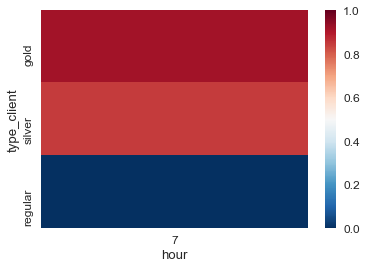

In [140]:
tt = ds.pivot_table(columns=['hour'], index=['type_client'], values='client_missed', aggfunc='mean').reindex(['gold','silver','regular'])
sns.heatmap(tt, vmin=0, vmax=1, cmap='RdBu_r')
del tt
plt.show()

In [141]:
line_loads_ds = get_line_loads(ds, time_to=get_datetime(8,0))

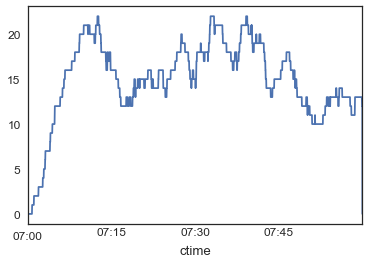

In [142]:
(line_loads_ds>0).sum(1).fillna(0).plot()
plt.show()

In [143]:
ds

,id_connection,id_operator,id_client,id_line,time_start_connection,time_to_service,connection_closed,type_client,time_start_call,client_max_waiting_time,client_missed,type_operator,operator_start_work_time,client_priority,time_quque_from,queue_exit,hour
0,0,2,0,0,2018-01-01 07:00:01,00:10:00,True,regular,2018-01-01 07:00:01,300,0,silver,2018-01-01 07:00:00,3,2018-01-01 07:00:01,True,7
1,1,0,2,1,2018-01-01 07:00:48,00:10:00,True,regular,2018-01-01 07:00:48,300,0,regular,2018-01-01 07:00:00,3,2018-01-01 07:00:48,True,7
2,2,4,4,2,2018-01-01 07:01:08,00:10:00,True,regular,2018-01-01 07:01:08,300,0,regular,2018-01-01 07:00:00,3,2018-01-01 07:01:08,True,7
3,3,5,5,3,2018-01-01 07:01:57,00:10:00,True,regular,2018-01-01 07:01:57,300,0,regular,2018-01-01 07:00:00,3,2018-01-01 07:01:57,True,7
4,4,6,6,4,2018-01-01 07:02:43,00:10:00,True,regular,2018-01-01 07:02:43,300,0,regular,2018-01-01 07:00:00,3,2018-01-01 07:02:43,True,7
5,5,7,7,5,2018-01-01 07:02:54,00:10:00,True,regular,2018-01-01 07:02:54,300,0,regular,2018-01-01 07:00:00,3,2018-01-01 07:02:54,True,7
6,6,8,8,6,2018-01-01 07:03:08,00:10:00,True,regular,2018-01-01 07:03:08,300,0,regular,2018-01-01 07:00:00,3,2018-01-01 07:03:08,True,7
7,7,9,9,7,2018-01-01 07:03:11,00:10:00,True,regular,2018-01-01 07:03:11,300,0,regular,2018-01-01 07:00:00,3,2018-01-01 07:03:11,True,7
8,8,10,11,8,2018-01-01 07:04:01,00:10:00,True,regular,2018-01-01 07:04:01,300,0,regular,2018-01-01 07:00:00,3,2018-01-01 07:04:01,True,7
9,9,11,12,9,2018-01-01 07:04:05,00:10:00,True,regular,2018-01-01 07:04:05,300,0,regular,2018-01-01 07:00:00,3,2018-01-01 07:04:05,True,7


In [144]:
ds[ds['type_operator']=='silver']['client_missed']

0     0
21    0
36    0
51    0
72    0
84    0
Name: client_missed, dtype: int32

In [148]:
ds.pivot_table(index='type_operator', columns='type_client', values='id_connection', aggfunc='count', fill_value=0)

type_client,regular,silver
type_operator,,
regular,90,0
silver,1,5


# Что ещё надо добавить

Отдельные линии для випов

Начальные задержки для каждого звонка

Разные типы звонков

Случайное время готовности ожидания клиента

Случайное время обслуживания для оператора (+поправки на тип оператора) для соединения

Поиск оптимальной комбинации